In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error,  mean_squared_error

import os
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_CUDNN_DETERMINISTIC'] = '1' # Untuk CuDNN (GPU)

# Set threading options before any TensorFlow operations
# Moved these lines here to ensure they run before TF initializes heavily
tf.config.threading.set_inter_op_parallelism_threads(1)
tf.config.threading.set_intra_op_parallelism_threads(1)

In [2]:
# Set seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# --- 0. Generate Dummy Daily Data (Initial Setup) ---
def generate_daily_dummy_data(start_date='2023-01-01', end_date='2024-12-31'):
    dates = pd.date_range(start=start_date, end=end_date, freq='D')
    df = pd.DataFrame(dates, columns=['Date'])
    df.set_index('Date', inplace=True)

    df['Income'] = np.random.normal(loc=50000, scale=10000, size=len(df))
    salary_amount = 5000000
    salary_dates = df.index[df.index.day == 25]
    for s_date in salary_dates:
        df.loc[s_date, 'Income'] += np.random.normal(loc=salary_amount, scale=salary_amount * 0.05)
        if (s_date + pd.Timedelta(days=1)) in df.index:
            df.loc[s_date + pd.Timedelta(days=1), 'Income'] += np.random.normal(loc=salary_amount * 0.1, scale=salary_amount * 0.02)

    df['Expenses'] = np.random.normal(loc=20000, scale=5000, size=len(df))
    df['DayOfWeek_temp'] = df.index.dayofweek
    df.loc[df['DayOfWeek_temp'].isin([5, 6]), 'Expenses'] *= np.random.normal(1.3, 0.1)
    df['DayOfMonth_temp'] = df.index.day
    df['Expenses'] += (df['DayOfMonth_temp'] / 30) * 10000
    df['Trend_Factor_temp'] = np.linspace(1, 1.05, len(df))
    df['Expenses'] *= df['Trend_Factor_temp']
    spike_days = df.sample(frac=0.01, random_state=42).index
    for s_day in spike_days:
        df.loc[s_day, 'Expenses'] += np.random.normal(loc=100000, scale=50000)
    df['Expenses'] = df['Expenses'].apply(lambda x: max(0, x))
    df['Net Cashflow'] = df['Income'] - df['Expenses']
    df.drop(columns=['DayOfWeek_temp', 'DayOfMonth_temp', 'Trend_Factor_temp'], inplace=True)
    return df

# Inisialisasi df_dummy
df_daily = generate_daily_dummy_data()
print("Daily Dummy Data Generated:")
print(df_daily.head())
print(f"Total days: {len(df_daily)}\n")

Daily Dummy Data Generated:
                  Income      Expenses  Net Cashflow
Date                                                
2023-01-01  54967.141530  27730.016451  27237.125080
2023-01-02  48617.356988  21556.648053  27060.708935
2023-01-03  56476.885381  14325.240299  42151.645082
2023-01-04  65230.298564  23239.096764  41991.201800
2023-01-05  47658.466253  24726.367885  22932.098368
Total days: 731



In [3]:
def preprocess_data(df_daily):
    print("1. Preprocessing Data...")

    # Agregasi data ke level bulanan
    monthly_data = df_daily.resample('ME').agg({
        'Income': 'sum',
        'Expenses': 'sum',
        'Net Cashflow': 'sum'
    })

    # Tambahkan kolom moving average (misal 3 bulan)
    # Ini akan menjadi fitur untuk model
    monthly_data['Net_Cashflow_MA3'] = monthly_data['Net Cashflow'].rolling(window=3, min_periods=1).mean()
    monthly_data['Income_MA3'] = monthly_data['Income'].rolling(window=3, min_periods=1).mean()
    monthly_data['Expenses_MA3'] = monthly_data['Expenses'].rolling(window=3, min_periods=1).mean()

    # Tambahkan fitur musiman: bulan (month)
    monthly_data['Month'] = monthly_data.index.month

    # Tambahkan fitur event spesial (misal: Lebaran)
    # Asumsi Lebaran biasanya Maret/April/Mei (bergeser setiap tahun)
    # Untuk dummy data ini, kita asumsikan bulan April dan Mei setiap tahunnya ada potensi event spesial
    monthly_data['is_lebaran_month'] = ((monthly_data.index.month == 4) | (monthly_data.index.month == 5)).astype(int)

    # Scaling (normalisasi)
    # Target adalah Net Cashflow bulan berikutnya, jadi kita perlu scaler untuk target juga
    # Fitur-fitur yang akan digunakan sebagai input (X) dan target (y)
    features = ['Income', 'Expenses', 'Net Cashflow', 'Net_Cashflow_MA3',
                'Income_MA3', 'Expenses_MA3', 'Month', 'is_lebaran_month']
    target = 'Net Cashflow' # Target adalah cashflow netto bulan berikutnya

    # Buat lagged features untuk input model
    # X akan berisi data historis dari `sequence_length` bulan ke belakang
    # y akan berisi Net Cashflow dari bulan `n+1` (target yang akan diprediksi)
    sequence_length = 3 # Lihat 3 bulan sebelumnya untuk memprediksi bulan berikutnya

    # Untuk prediksi bulan depan, targetnya adalah nilai Net Cashflow bulan ke-(i+sequence_length).
    # Fitur X adalah sekumpulan kolom dari bulan ke-i hingga bulan ke-(i+sequence_length-1).

    # Pisahkan data untuk scaling agar scaler hanya melihat data training
    train_size_ratio = 0.8
    train_data_len = int(len(monthly_data) * train_size_ratio)

    # Data sebelum scaling
    data_for_scaling_features = monthly_data[features].values
    data_for_scaling_target = monthly_data[target].values.reshape(-1, 1)

    # Fit scaler pada data training
    scaler_features = MinMaxScaler(feature_range=(0, 1))
    scaler_target = MinMaxScaler(feature_range=(0, 1))

    # Skalakan data training dan seluruh data dengan scaler yang sudah di-fit
    scaled_features = scaler_features.fit_transform(data_for_scaling_features)
    scaled_target = scaler_target.fit_transform(data_for_scaling_target)

    # Buat dataset sekuensial untuk LSTM
    X, y = [], []
    for i in range(len(monthly_data) - sequence_length):
        X.append(scaled_features[i:(i + sequence_length), :])
        y.append(scaled_target[i + sequence_length, 0]) # Target adalah Net Cashflow bulan ke-(i + sequence_length)

    X, y = np.array(X), np.array(y)

    print(f"Monthly data shape: {monthly_data.shape}")
    print(f"Processed X shape: {X.shape}, y shape: {y.shape}")
    print("Preprocessing complete.\n")
    return X, y, monthly_data, scaler_features, scaler_target, sequence_length, features


In [4]:
# --- Pipeline Langkah 2: Pemilihan Model LSTM ---
def build_lstm_model(input_shape):
    print("2. Building LSTM Model...")
    model = Sequential([
        tf.keras.Input(shape=input_shape),
        LSTM(units=100, return_sequences=True),
        Dropout(0.2),
        LSTM(units=50, return_sequences=False),
        Dropout(0.2),
        Dense(units=25, activation='relu'),
        Dense(units=1) # Output 1 nilai (Net Cashflow bulan berikutnya)
    ])
    model.compile(optimizer='adam', loss='mse')
    model.summary()
    print("Model built.\n")
    return model


In [5]:
# --- Pipeline Langkah 3: Training Model ---
# Add scaler_features and scaler_target as arguments
def train_model(model, X, y, monthly_data_dates, sequence_length, scaler_features, scaler_target):
    print("3. Training Model...")

    # Bagi dataset ke data latih (misalnya 80%) dan data uji (20%).
    # Untuk deret waktu, pembagian harus kronologis.
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    # Early stopping untuk mencegah overfitting
    early_stop = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True, mode='min')

    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=200, # Max epochs, EarlyStopping akan menghentikan lebih awal
        batch_size=1, # Batch size kecil karena data bulanan sedikit
        verbose=1,
        callbacks=[early_stop]
    )

    print("\nModel training complete.")

    # Plot training history
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Prediksi pada data uji
    y_test_pred_scaled = model.predict(X_test)

    # Inverse transform untuk mendapatkan nilai asli
    y_test_pred = scaler_target.inverse_transform(y_test_pred_scaled)
    y_test_actual = scaler_target.inverse_transform(y_test.reshape(-1, 1))

    # Evaluasi metrik
    mae = mean_absolute_error(y_test_actual, y_test_pred)
    rmse = np.sqrt(mean_squared_error(y_test_actual, y_test_pred))
    mape = np.mean(np.abs((y_test_actual - y_test_pred) / (y_test_actual + 1e-8))) * 100 # Tambah epsilon untuk stabilitas

    print(f"\n--- Model Evaluation on Test Data ---")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAPE: {mape:.2f}%")

    # Plot prediksi vs data aktual
    # Mendapatkan tanggal yang sesuai untuk data uji
    # Data X dimulai dari monthly_data[sequence_length]
    # Data test dimulai dari index train_size_X di X array
    # Jadi, tanggal awal test set adalah monthly_data.index[sequence_length + train_size]
    test_dates = monthly_data_dates.index[sequence_length + train_size: sequence_length + train_size + len(y_test_actual)]

    plt.figure(figsize=(15, 7))
    plt.plot(test_dates, y_test_actual, label='Actual Net Cashflow')
    plt.plot(test_dates, y_test_pred, label='Predicted Net Cashflow (Test)', linestyle='--')
    plt.title('Actual vs Predicted Net Cashflow (Monthly Test Data)')
    plt.xlabel('Date')
    plt.ylabel('Net Cashflow (Rupiah)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Return scaler_features and scaler_target as they might be needed elsewhere
    return model, y_test_pred, y_test_actual, mae, rmse, mape, test_dates, train_size, scaler_features, scaler_target

In [6]:
# --- Pipeline Langkah 4: Prediksi Bulan Depan ---
def predict_next_month(model, monthly_data, scaler_features, scaler_target, sequence_length, features):
    print("4. Predicting Next Month's Cashflow...")

    # Ambil data terbaru untuk input prediksi
    last_sequence_raw = monthly_data[features].iloc[-sequence_length:].values

    # Skalakan data input menggunakan scaler yang sudah dilatih
    last_sequence_scaled = scaler_features.transform(last_sequence_raw)
    last_sequence_scaled = last_sequence_scaled.reshape(1, sequence_length, len(features)) # Reshape untuk model LSTM

    # Prediksi
    next_month_pred_scaled = model.predict(last_sequence_scaled, verbose=0)

    # Inverse transform hasil prediksi untuk mendapatkan nilai asli
    next_month_pred = scaler_target.inverse_transform(next_month_pred_scaled)[0, 0]

    # Menentukan tanggal bulan depan
    last_month_date = monthly_data.index[-1]
    next_month_date = last_month_date + pd.DateOffset(months=1)

    print(f"Prediksi Net Cashflow untuk {next_month_date.strftime('%Y-%m')}: Rp {next_month_pred:.2f}")
    print("Prediction complete.\n")
    return next_month_pred, next_month_date



In [7]:
# --- Pipeline Langkah 5: Visualisasi ---
def visualize_forecast(monthly_data, next_month_pred, next_month_date):
    print("5. Visualizing Forecast...")

    # Gabungkan data aktual dan prediksi
    combined_index = monthly_data.index.tolist() + [next_month_date]
    full_data_index = pd.DatetimeIndex(combined_index).unique()
    full_data = monthly_data['Net Cashflow'].reindex(full_data_index)
    full_data.loc[next_month_date] = next_month_pred

    plt.figure(figsize=(16, 8))
    plt.plot(monthly_data.index, monthly_data['Net Cashflow'], label='Actual Monthly Net Cashflow', color='blue', marker='o')
    plt.plot(next_month_date, next_month_pred, label='Predicted Next Month Cashflow', color='red', marker='X', markersize=10)

    # Menambahkan garis putus-putus ke prediksi
    # Ambil 3 bulan terakhir dari data aktual untuk koneksi
    last_3_months_actual = monthly_data['Net Cashflow'].iloc[-3:]
    # Combine the index and the future date into a list and then convert to DatetimeIndex
    prediction_line_dates = pd.DatetimeIndex(last_3_months_actual.index.tolist() + [next_month_date])
    prediction_line_values = pd.concat([last_3_months_actual, pd.Series([next_month_pred], index=[next_month_date])]).reindex(prediction_line_dates)
    plt.plot(prediction_line_dates, prediction_line_values, color='red', linestyle='--', alpha=0.7)


    plt.title('Monthly Net Cashflow: Actual vs Predicted Next Month')
    plt.xlabel('Date')
    plt.ylabel('Net Cashflow (Rupiah)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    print("Visualization complete.\n")

    # Catatan tentang Confidence Interval:
    print("Visualisasi di atas hanya menampilkan prediksi titik.")


In [8]:
# --- Pipeline Langkah 6: Analisis Tren ---
def analyze_trend(monthly_data, next_month_pred, next_month_date):
    print("6. Analyzing Trend...")

    # Ambil nilai rata-rata Net Cashflow dari 3 bulan terakhir (atau 1 bulan jika data sedikit)
    # untuk membandingkan dengan prediksi bulan depan
    compare_window = min(3, len(monthly_data)) # Ambil min 3 bulan atau semua yang ada
    last_actual_avg = monthly_data['Net Cashflow'].iloc[-compare_window:].mean()

    # Tentukan ambang batas untuk perubahan tren (misal 5% dari rata-rata terakhir)
    threshold = last_actual_avg * 0.05

    trend_status = ""
    if next_month_pred > last_actual_avg + threshold:
        trend_status = 'Upward Trend'
    elif next_month_pred < last_actual_avg - threshold:
        trend_status = 'Downward Trend'
    else:
        trend_status = 'Stable Trend'

    print(f"Rata-rata Net Cashflow {compare_window} bulan terakhir (aktual): Rp {last_actual_avg:.2f}")
    print(f"Prediksi Net Cashflow bulan {next_month_date.strftime('%Y-%m')}: Rp {next_month_pred:.2f}")
    print(f"Status Tren Prediksi: {trend_status}")
    print("Trend analysis complete.\n")
    return trend_status


1. Preprocessing Data...
Monthly data shape: (24, 8)
Processed X shape: (21, 3, 8), y shape: (21,)
Preprocessing complete.

2. Building LSTM Model...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 3, 100)              │          43,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 3, 100)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50)                  │          30,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 25)                  │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 75,101 (293.36 KB)

 Trainable params: 75,101 (293.36 KB)

 Non-trainable params: 0 (0.00 B)

Model built.

3. Training Model...
Epoch 1/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 56ms/step - loss: 0.3038 - val_loss: 0.2987
Epoch 2/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1840 - val_loss: 0.1623
Epoch 3/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1027 - val_loss: 0.1485
Epoch 4/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0734 - val_loss: 0.1552
Epoch 5/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0582 - val_loss: 0.1604
Epoch 6/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0579 - val_loss: 0.1657
Epoch 7/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0553 - val_loss: 0.1769
Epoch 8/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0856 - val_loss: 0.1792
Epoch 9/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0423 - val_loss: 0.1829
Epoch 10/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0500 - val_loss: 0.1957
Epoch 11/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0367 - val_loss: 0.2066
Epoch 12/200
16/16 ━━

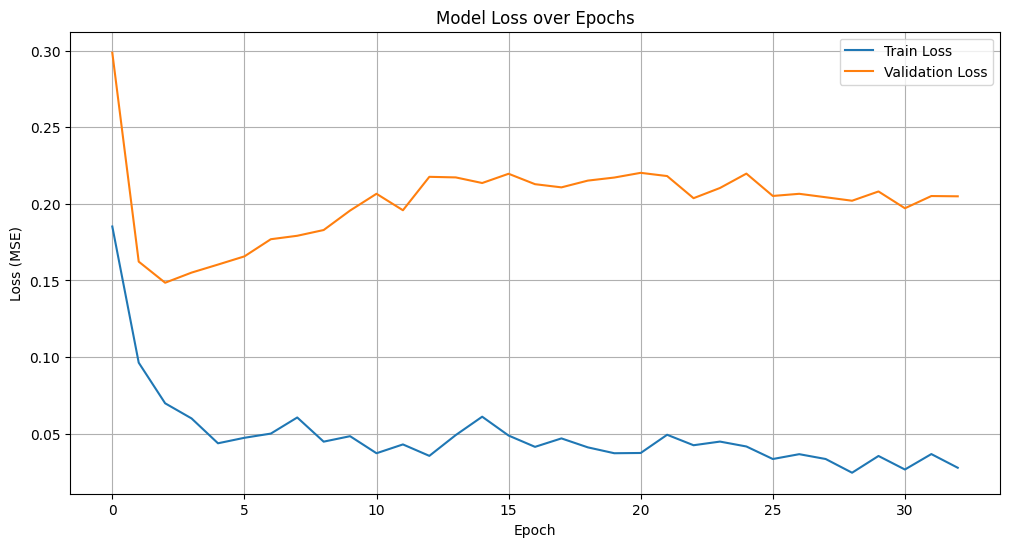

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step

--- Model Evaluation on Test Data ---
MAE: 237926.49
RMSE: 299103.39
MAPE: 3.77%


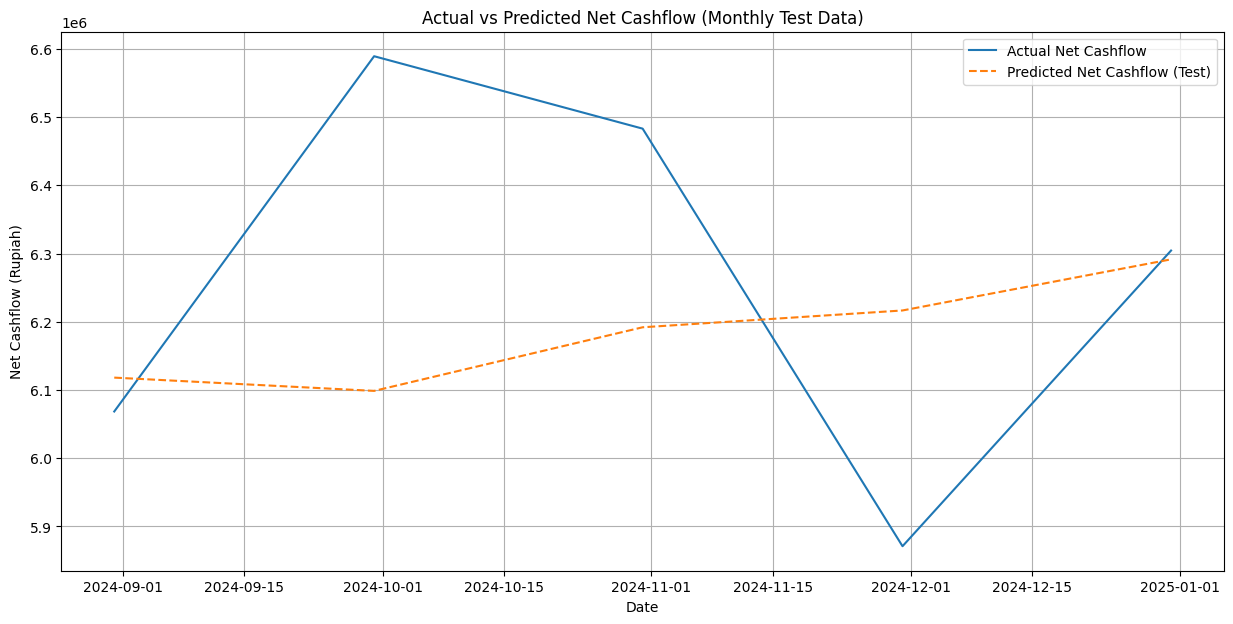

4. Predicting Next Month's Cashflow...
Prediksi Net Cashflow untuk 2025-01: Rp 6234767.50
Prediction complete.

5. Visualizing Forecast...


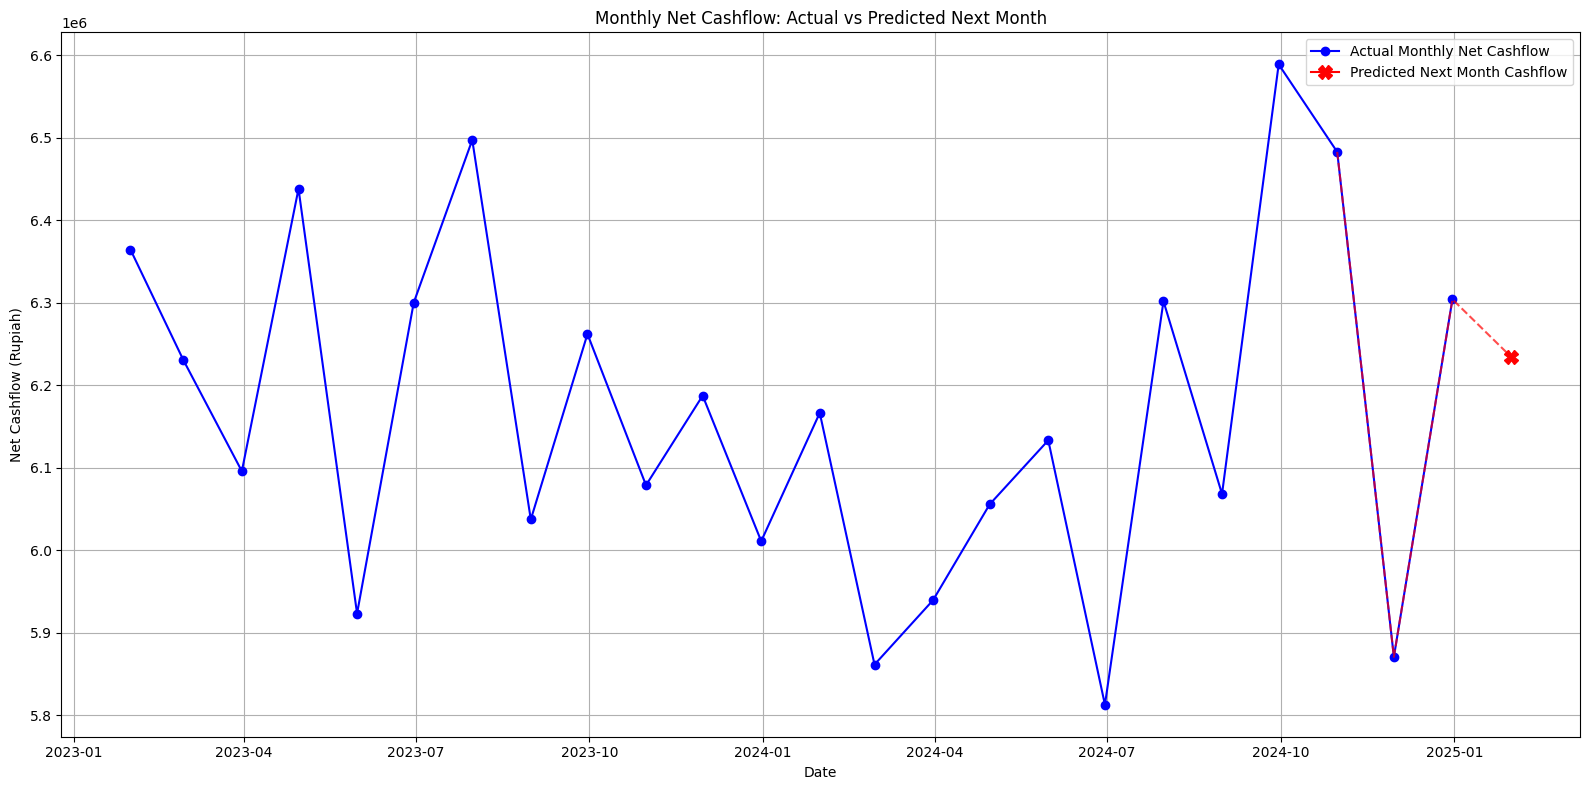

Visualization complete.

Visualisasi di atas hanya menampilkan prediksi titik.
6. Analyzing Trend...
Rata-rata Net Cashflow 3 bulan terakhir (aktual): Rp 6219454.41
Prediksi Net Cashflow bulan 2025-01: Rp 6234767.50
Status Tren Prediksi: Stable Trend
Trend analysis complete.


--- Project Summary ---
Final MAE on test data: 237926.49
Final RMSE on test data: 299103.39
Final MAPE on test data: 3.77%
Predicted Net Cashflow for 2025-01: Rp 6234767.50
Predicted Trend: Stable Trend


In [9]:
# --- Main Execution Pipeline ---
if __name__ == "__main__":
    # Langkah 0: Generate Dummy Data (jika belum ada)
    # Ini akan dijalankan setiap kali script dijalankan secara mandiri
    # Jika Anda menggunakan Colab, pastikan ini dijalankan di awal sesi atau setelah reset runtime
    df_daily_main = generate_daily_dummy_data()
    # Langkah 1: Preprocessing Data
    X, y, monthly_data_processed, scaler_features_main, scaler_target_main, seq_len_main, features_list_main = preprocess_data(df_daily_main)

    # Langkah 2: Pemilihan Model LSTM
    input_shape = (X.shape[1], X.shape[2]) # (sequence_length, num_features)
    model_main = build_lstm_model(input_shape)

    # Langkah 3: Training Model
    model_main, y_pred_test, y_actual_test, mae_val, rmse_val, mape_val, test_dates_val, train_size_val, scaler_features_from_train, scaler_target_from_train = train_model(model_main, X, y, monthly_data_processed, seq_len_main, scaler_features_main, scaler_target_main)

    # Langkah 4: Prediksi Bulan Depan
    next_month_pred_val, next_month_date_val = predict_next_month(model_main, monthly_data_processed, scaler_features_main, scaler_target_main, seq_len_main, features_list_main)

    # Langkah 5: Visualisasi
    visualize_forecast(monthly_data_processed, next_month_pred_val, next_month_date_val)

    # Langkah 6: Analisis Tren
    trend_status_val = analyze_trend(monthly_data_processed, next_month_pred_val, next_month_date_val)

    print("\n--- Project Summary ---")
    print(f"Final MAE on test data: {mae_val:.2f}")
    print(f"Final RMSE on test data: {rmse_val:.2f}")
    print(f"Final MAPE on test data: {mape_val:.2f}%")
    print(f"Predicted Net Cashflow for {next_month_date_val.strftime('%Y-%m')}: Rp {next_month_pred_val:.2f}")
    print(f"Predicted Trend: {trend_status_val}")